In [8]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df: DataFrame = pd.read_csv('data/moscow_apartment_listings.csv')
df.head()

,price,repair,year_built_empty,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,...,subway_offers,address_offers,rooms,footage,floor,max_floor,first_floor,last_floor,AO,hm
0,8000000,3,0,42,59,960,0.0,55.609009,37.734632,17166,...,5,1.0,1,39.4,11,12,0,0,UAO,panel
1,7200000,2,0,43,59,802,0.0,55.608760,37.741936,17166,...,9,1.0,1,35.6,2,9,0,0,UAO,panel
2,10300000,2,0,43,59,638,0.0,55.610207,37.742495,17166,...,9,2.0,2,53.0,5,12,0,0,UAO,panel
3,8500000,2,0,43,59,929,0.0,55.624017,37.740373,17166,...,5,1.0,2,44.1,8,9,0,0,UAO,panel
4,9000000,2,0,43,59,785,0.0,55.609107,37.740430,17166,...,5,1.0,2,44.2,6,9,0,0,UAO,panel


## Описательный анализ данных:
Мы рассчитаем основные статистические показатели (среднее, медиану, стандартное отклонение и т.д.) для каждого числового столбца в нашем датасете. Это поможет нам лучше понять распределение и характеристики данных.

In [26]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', ' тыс.', ' мил.'][magnitude])

df_normal: DataFrame = df[['price', 'repair', 'house_age', 'dist_to_subway', 'footage', 'floor', 'rooms']]
df2: DataFrame = df_normal.describe()
for frame in df2:
    df2[frame] = df2[frame].apply(human_format)

df2

,price,repair,house_age,dist_to_subway,footage,floor,rooms
count,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.,12.18 тыс.
mean,10.87 мил.,2.27,36.36,928.35,46.15,6.87,1.60
std,3.04 мил.,0.79,21.41,532.44,10.54,5.31,0.49
min,4.90 мил.,1.00,0.00,11.00,30.10,1.00,1.00
25%,8.50 мил.,2.00,17.00,548.00,38.00,3.00,1.00
50%,10.20 мил.,2.00,42.00,820.00,44.50,5.00,2.00
75%,12.70 мил.,3.00,54.00,1.18 тыс.,53.40,9.00,2.00
max,20.00 мил.,4.00,130.00,2.99 тыс.,89.90,38.00,2.00


### Вывод:
    Цена (price): Средняя цена квартиры составляет примерно 10.87 миллиона рублей, со стандартным отклонением 3.04 миллиона рублей. Минимальная цена - 4.9 миллиона рублей, максимальная - 20 миллионов рублей.

    Состояние ремонта (repair): Среднее значение состояния ремонта близко к 2, что указывает на то, что большинство квартир имеют среднее качество ремонта.

    Возраст дома (house_age): Средний возраст дома составляет около 36 лет, со стандартным отклонением в 21 год.

    Расстояние до метро (dist_to_subway): В среднем квартиры находятся на расстоянии около 928 метров от метро.

    Площадь квартир (footage): Средняя площадь квартиры составляет около 46 квадратных метров.

    Этаж (floor) и максимальное количество этажей (max_floor): Средний этаж, на котором расположена квартира, - это 7-й этаж, при этом в здании в среднем 13 этажей.

    Количество комнат (rooms): Большинство квартир имеют 1 или 2 комнаты.

# Визуализация распределения ключевых переменных

/home/likimiad/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/likimiad/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


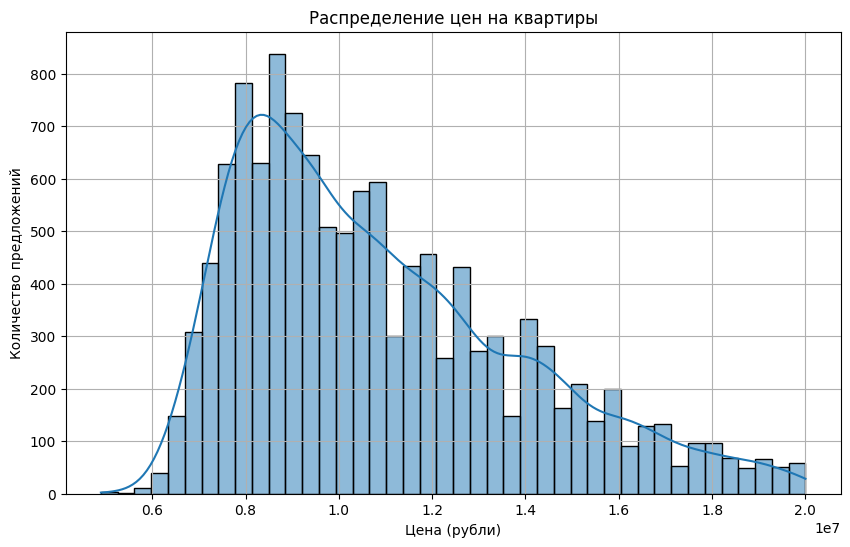

/home/likimiad/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/likimiad/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


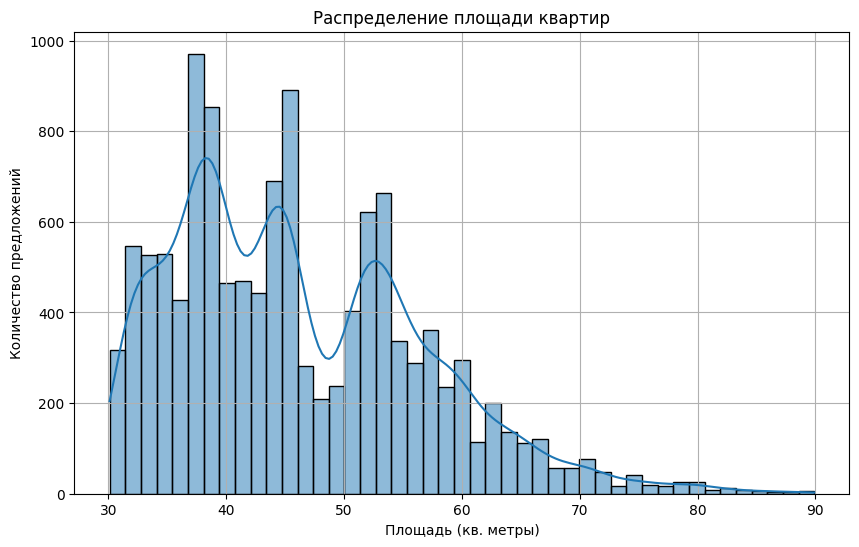

/home/likimiad/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/likimiad/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


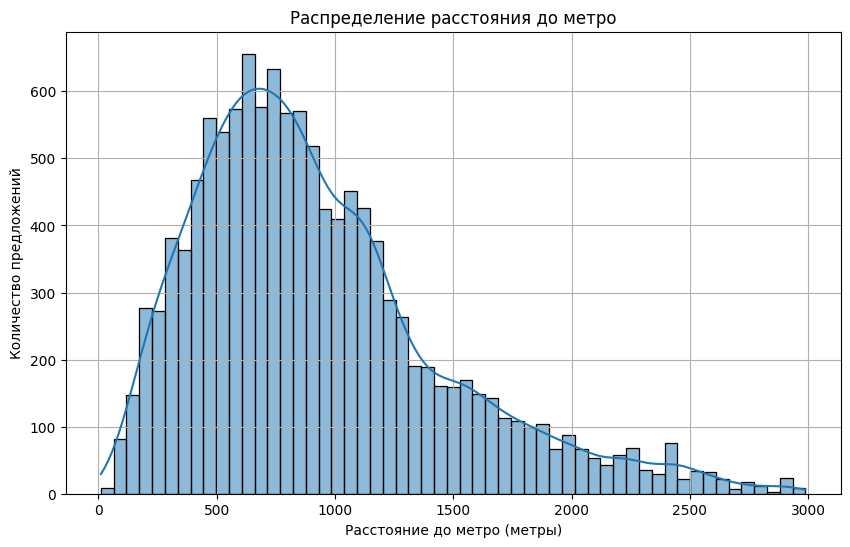

In [11]:
# Визуализация распределения ключевых переменных

# Гистограмма цен
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (рубли)')
plt.ylabel('Количество предложений')
plt.grid(True)
plt.show()

# Гистограмма площади квартир
plt.figure(figsize=(10, 6))
sns.histplot(df['footage'], kde=True)
plt.title('Распределение площади квартир')
plt.xlabel('Площадь (кв. метры)')
plt.ylabel('Количество предложений')
plt.grid(True)
plt.show()

# Гистограмма расстояния до метро
plt.figure(figsize=(10, 6))
sns.histplot(df['dist_to_subway'], kde=True)
plt.title('Распределение расстояния до метро')
plt.xlabel('Расстояние до метро (метры)')
plt.ylabel('Количество предложений')
plt.grid(True)
plt.show()
